In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
# Learning stuff
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [9]:
nyc_health = pd.read_csv(r'C:\Users\willd\Documents\Georgia Tech\CSE6424\Project\nychealth_w_desert_measures.csv')

In [10]:
nyc_health

,StateAbbr,StateDesc,CountyName,CountyFIPS,TractFIPS,TotalPopulation,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,closest_transport_nodes_y,closest_worship_nodes,closest_worship_nodes_travel_time,closest_worship_nodes_x,closest_worship_nodes_y,nodes,nodes_x,nodes_y,physical_dist,transport_dist
0,NY,New York,Kings,36047,36047009600,6126,34.5,"(29.5, 39.2)",15.1,"(14.5, 15.7)",...,40.649776,42521189.0,4.0,-74.008987,40.649776,42477077.0,-74.005783,40.646015,0.158174,0.498002
1,NY,New York,Kings,36047,36047011600,4816,28.0,"(23.5, 32.6)",16.9,"(16.2, 17.6)",...,40.634357,42486091.0,7.0,-74.010742,40.634357,42473465.0,-74.005005,40.636425,0.377913,0.535944
2,NY,New York,Kings,36047,36047046000,3729,15.0,"(12.9, 17.3)",19.0,"(18.2, 19.8)",...,40.635517,42485802.0,9.0,-73.963348,40.635517,42517167.0,-73.968407,40.631508,0.797871,0.617204
3,NY,New York,Bronx,36005,36005031400,1966,13.8,"(11.8, 15.9)",22.0,"(21.0, 22.9)",...,40.858040,470207824.0,4.0,-73.846474,40.858040,42745688.0,-73.845444,40.860939,0.679142,0.333808
4,NY,New York,Bronx,36005,36005042300,4100,26.7,"(22.7, 31.0)",16.9,"(16.3, 17.5)",...,40.878746,42739327.0,5.0,-73.872543,40.878746,42757892.0,-73.876549,40.876602,0.000000,0.412595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2112,NY,New York,Queens,36081,36081113900,3322,13.9,"(11.9, 16.0)",19.7,"(18.9, 20.6)",...,40.761730,42892953.0,4.0,-73.791771,40.761730,42873728.0,-73.790245,40.763653,0.169904,0.249437
2113,NY,New York,Kings,36047,36047058000,3365,16.8,"(15.1, 18.5)",18.3,"(17.7, 18.9)",...,40.598938,42534874.0,0.0,-73.955475,40.598938,42534874.0,-73.955475,40.598938,0.286232,0.000000
2114,NY,New York,New York,36061,36061013900,9257,7.6,"( 6.4, 9.4)",17.3,"(16.5, 18.1)",...,40.767399,42435716.0,3.0,-73.982361,40.767399,42431560.0,-73.986206,40.767246,0.556792,0.324271
2115,NY,New York,Queens,36081,36081041400,4033,19.8,"(16.8, 23.0)",20.3,"(19.4, 21.2)",...,40.696037,42916014.0,5.0,-73.782730,40.696037,42900823.0,-73.781059,40.698818,0.307807,0.339795


In [11]:
nyc_health.columns

Index(['StateAbbr', 'StateDesc', 'CountyName', 'CountyFIPS', 'TractFIPS',
       'TotalPopulation', 'ACCESS2_CrudePrev', 'ACCESS2_Crude95CI',
       'ARTHRITIS_CrudePrev', 'ARTHRITIS_Crude95CI', 'BINGE_CrudePrev',
       'BINGE_Crude95CI', 'BPHIGH_CrudePrev', 'BPHIGH_Crude95CI',
       'BPMED_CrudePrev', 'BPMED_Crude95CI', 'CANCER_CrudePrev',
       'CANCER_Crude95CI', 'CASTHMA_CrudePrev', 'CASTHMA_Crude95CI',
       'CERVICAL_CrudePrev', 'CERVICAL_Crude95CI', 'CHD_CrudePrev',
       'CHD_Crude95CI', 'CHECKUP_CrudePrev', 'CHECKUP_Crude95CI',
       'CHOLSCREEN_CrudePrev', 'CHOLSCREEN_Crude95CI',
       'COLON_SCREEN_CrudePrev', 'COLON_SCREEN_Crude95CI', 'COPD_CrudePrev',
       'COPD_Crude95CI', 'COREM_CrudePrev', 'COREM_Crude95CI',
       'COREW_CrudePrev', 'COREW_Crude95CI', 'CSMOKING_CrudePrev',
       'CSMOKING_Crude95CI', 'DENTAL_CrudePrev', 'DENTAL_Crude95CI',
       'DEPRESSION_CrudePrev', 'DEPRESSION_Crude95CI', 'DIABETES_CrudePrev',
       'DIABETES_Crude95CI', 'GHLTH_CrudePre

In [12]:
# Get the features
X = nyc_health[['closest_education_nodes_travel_time', 'closest_food_nodes_travel_time', 'closest_worship_nodes_travel_time', 'physical_dist', 'transport_dist']].to_numpy()
ys = {k: nyc_health[k].to_numpy() for k in nyc_health.columns if k.endswith('_CrudePrev')}

In [13]:
remove = pd.isnull(X).any(axis=1)
xs = {}
x_trains, x_tests, y_trains, y_tests = {}, {}, {}, {}
for k, v in ys.items():
    remove1 = pd.isnull(v)
    xs[k] = X[~(remove | remove1)]
    ys[k] = v[~(remove | remove1)]
    x_train, x_test, y_train, y_test = train_test_split(xs[k], ys[k], test_size=0.2)
    x_trains[k] = x_train
    y_trains[k] = y_train
    x_tests[k] = x_test
    y_tests[k] = y_test

In [14]:
unscaled_linear = {}
unscaled_elastic = {}
for k, v in x_trains.items():
    model = LinearRegression()
    model.fit(v, y_trains[k])
    unscaled_linear[k] = model
    model = ElasticNet()
    model.fit(v, y_trains[k])
    unscaled_elastic[k] = model

In [15]:
# Scale the data
for k, v in x_trains.items():
    s_scaler = StandardScaler()
    x_trains[k] = s_scaler.fit_transform(v.astype(float))
    x_tests[k] = s_scaler.transform(x_tests[k].astype(float))

In [16]:
scaled_linear = {}
scaled_elastic = {}
for k, v in x_trains.items():
    model = LinearRegression()
    model.fit(v, y_trains[k])
    scaled_linear[k] = model
    model = ElasticNet()
    model.fit(v, y_trains[k])
    scaled_elastic[k] = model

In [17]:
models = {}
for k, v in x_trains.items():
# Basic dense model
    model = Sequential()
    model.add(Dense(5*8, activation='relu'))
    model.add(Dense(5*4, activation='relu'))
    model.add(Dense(5*2, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='Adam', loss='mse')
    models[k] = model

In [18]:
# Fit the model
for k, model in tqdm(models.items()):
    model.fit(x=x_trains[k], y=y_trains[k],
          validation_data=(x_tests[k], y_tests[k]),
          batch_size=128, epochs=300, verbose=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [15:31<00:00, 31.05s/it]


ACCESS2_CrudePrev : 2906.276315686217


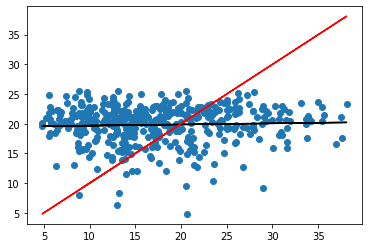

ARTHRITIS_CrudePrev : 1290.2629178504353


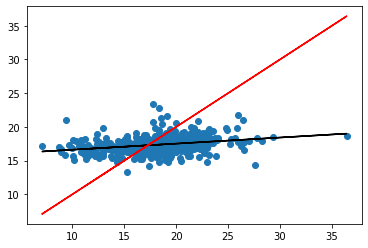

BINGE_CrudePrev : 1444.8893757583808


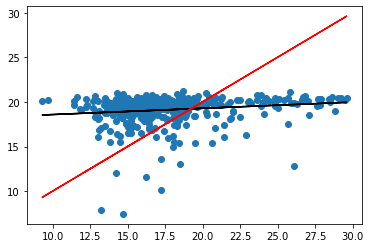

BPHIGH_CrudePrev : 1969.6660261692873


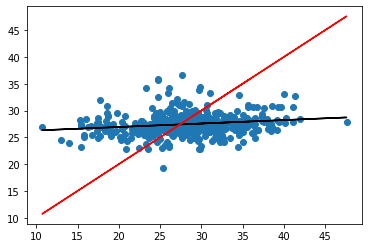

BPMED_CrudePrev : 1717.7206899428288


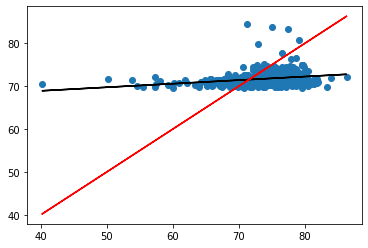

CANCER_CrudePrev : 508.84001165089245


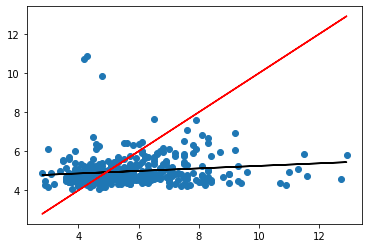

CASTHMA_CrudePrev : 680.1210214464203


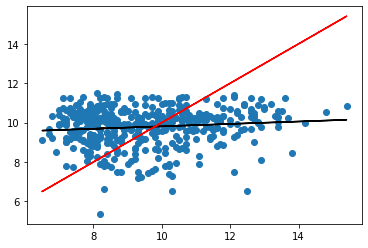

CERVICAL_CrudePrev : 1750.2936758029978


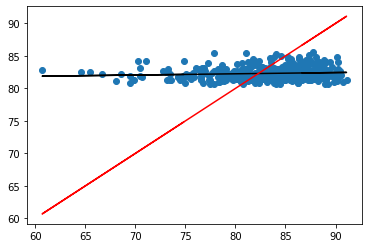

CHD_CrudePrev : 508.04139206593544


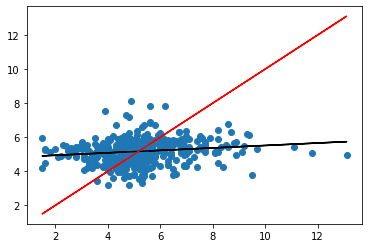

CHECKUP_CrudePrev : 1196.533951668382


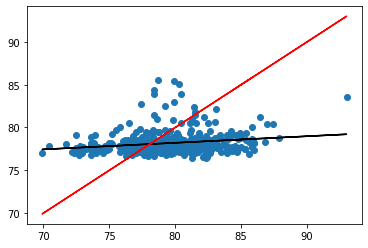

CHOLSCREEN_CrudePrev : 1153.515582117879


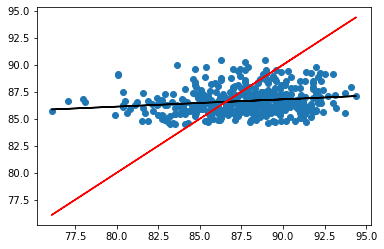

COLON_SCREEN_CrudePrev : 2564.5285167147867


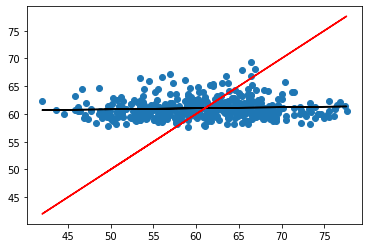

COPD_CrudePrev : 631.6960693871467


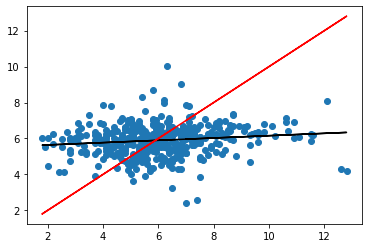

COREM_CrudePrev : 1637.8345684112064


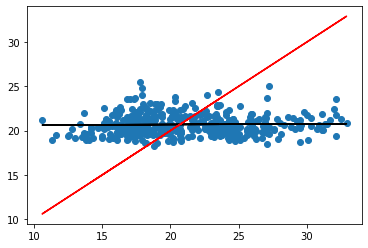

COREW_CrudePrev : 1276.418047279609


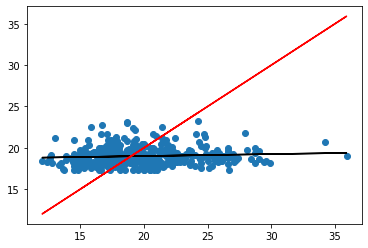

CSMOKING_CrudePrev : 1457.8676070566962


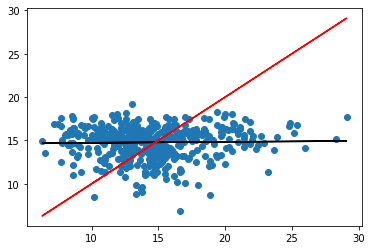

DENTAL_CrudePrev : 3864.748084040004


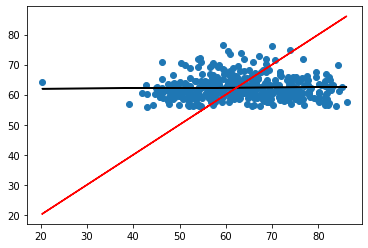

DEPRESSION_CrudePrev : 887.9086454422987


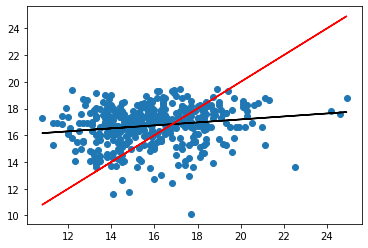

DIABETES_CrudePrev : 1276.9078407953825


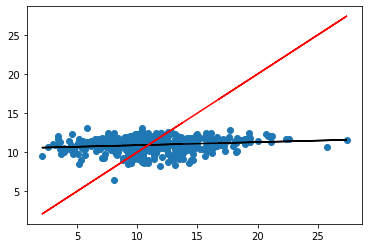

GHLTH_CrudePrev : 2796.7791956943065


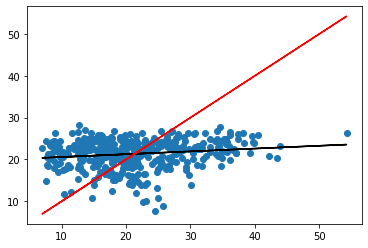

HIGHCHOL_CrudePrev : 1304.1202798431373


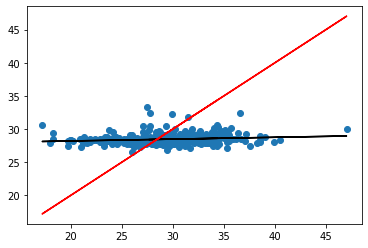

KIDNEY_CrudePrev : 296.6069642297341


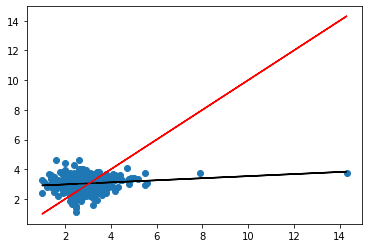

LPA_CrudePrev : 3058.4936565163316


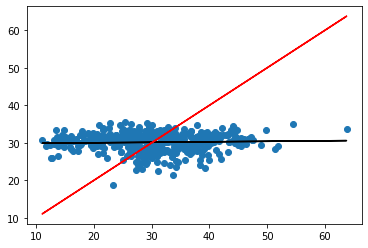

MAMMOUSE_CrudePrev : 1190.7716290506319


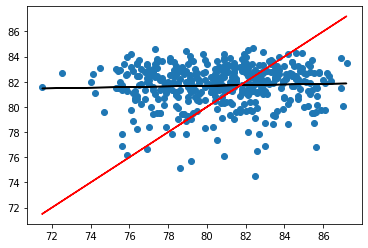

MHLTH_CrudePrev : 1119.2071523857264


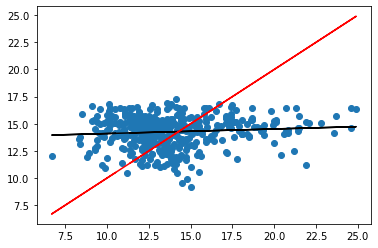

OBESITY_CrudePrev : 2436.160990233092


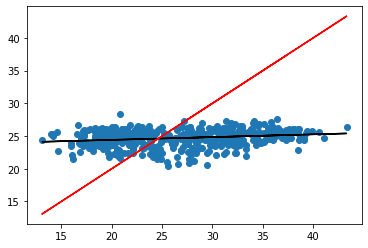

PHLTH_CrudePrev : 1240.1424010709602


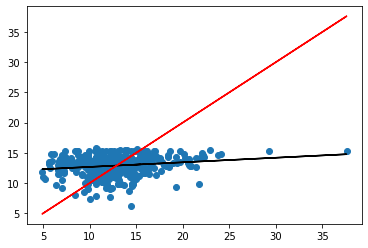

SLEEP_CrudePrev : 1713.5660671825835


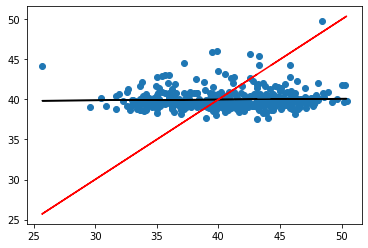

STROKE_CrudePrev : 396.98211235025474


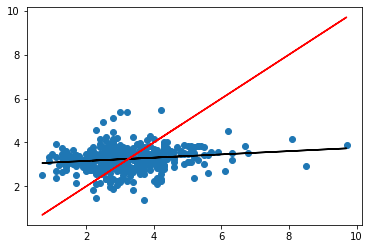

TEETHLOST_CrudePrev : 2615.867278280235


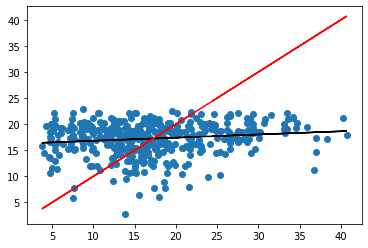

In [19]:
for k, model in unscaled_linear.items():
    y_pred = model.predict(x_tests[k])
    slope, intercept, r_value, p_value, std_err = linregress(y_tests[k], y_pred.flatten())
    print(k, ':', np.sum(np.abs(y_pred - y_tests[k])))
    plt.scatter(y_tests[k], y_pred)
    plt.plot(y_tests[k], slope*y_tests[k]+intercept, 'k')
    plt.plot(y_tests[k], y_tests[k], 'r')
    plt.show()

ACCESS2_CrudePrev : 2609.1076097605114


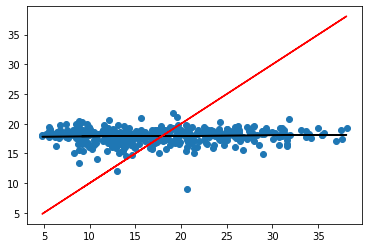

ARTHRITIS_CrudePrev : 1192.2024685264153


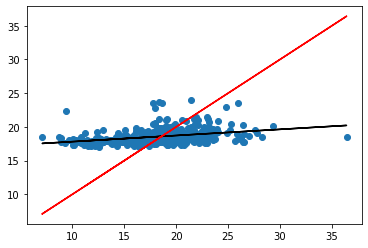

BINGE_CrudePrev : 1163.110804609486


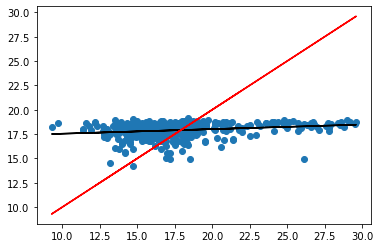

BPHIGH_CrudePrev : 1925.1848559765776


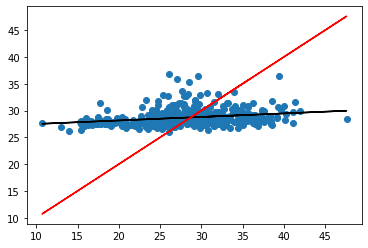

BPMED_CrudePrev : 1517.128025786782


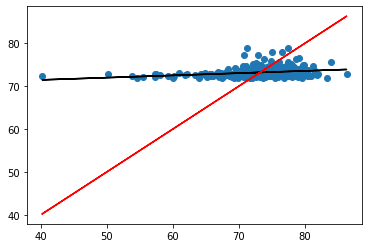

CANCER_CrudePrev : 504.1463201218002


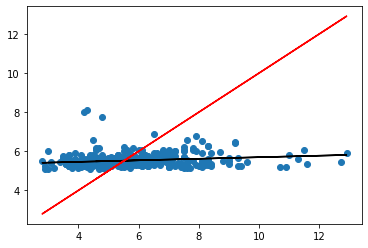

CASTHMA_CrudePrev : 606.0687506971126


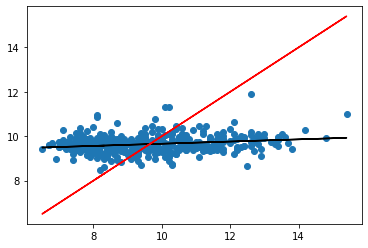

CERVICAL_CrudePrev : 1628.1325855166092


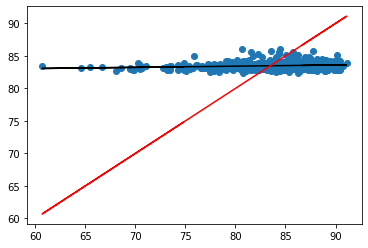

CHD_CrudePrev : 470.3536270250362


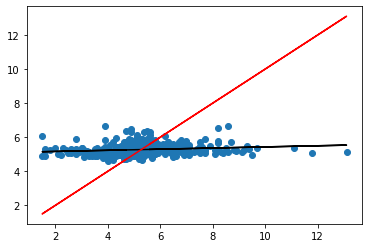

CHECKUP_CrudePrev : 1051.6640024143235


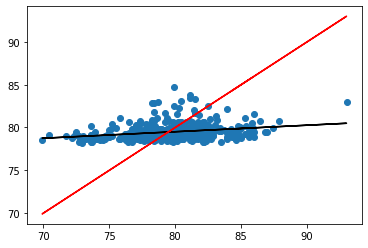

CHOLSCREEN_CrudePrev : 1054.999405491833


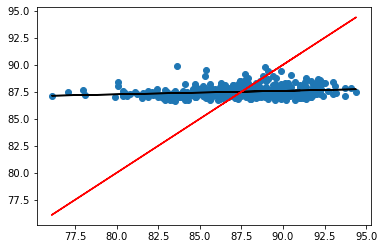

COLON_SCREEN_CrudePrev : 2547.7499786664093


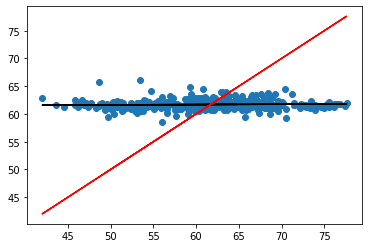

COPD_CrudePrev : 580.4141632953846


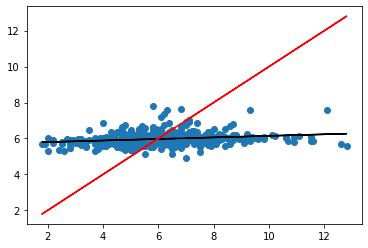

COREM_CrudePrev : 1610.554985002384


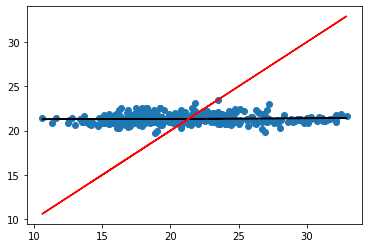

COREW_CrudePrev : 1252.868209991845


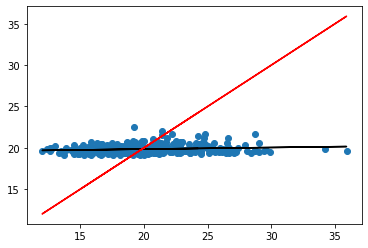

CSMOKING_CrudePrev : 1260.7072297558825


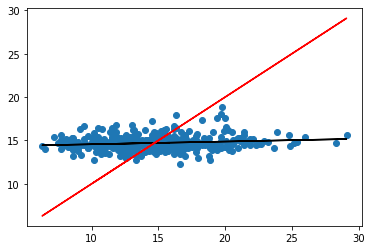

DENTAL_CrudePrev : 3687.9409668285534


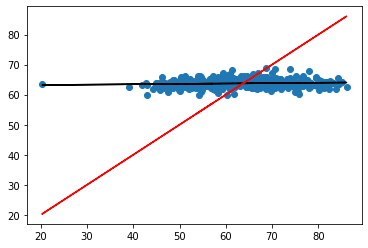

DEPRESSION_CrudePrev : 754.139794830252


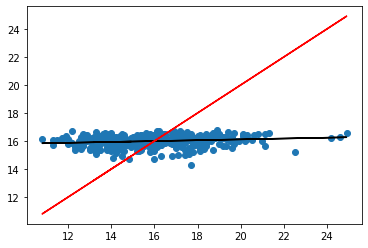

DIABETES_CrudePrev : 1248.556395730673


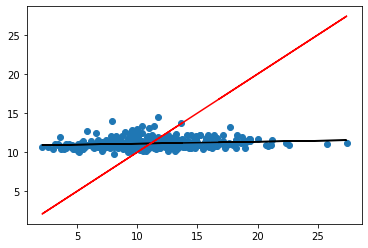

GHLTH_CrudePrev : 2619.3039185921007


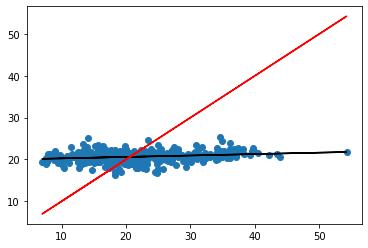

HIGHCHOL_CrudePrev : 1241.622005842936


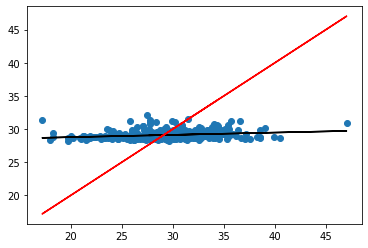

KIDNEY_CrudePrev : 257.33077555373995


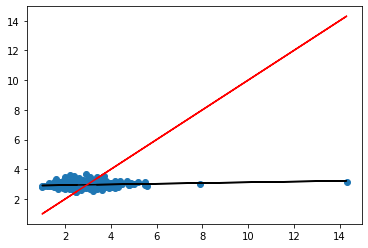

LPA_CrudePrev : 2867.198015575167


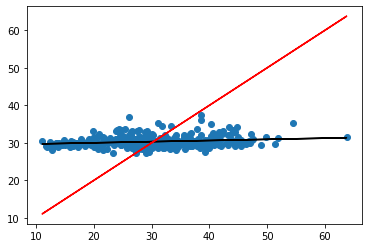

MAMMOUSE_CrudePrev : 1062.8265583729694


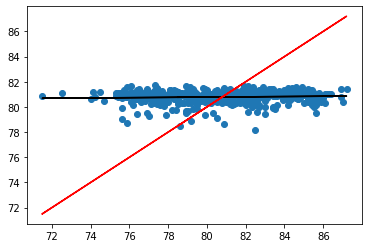

MHLTH_CrudePrev : 979.9585922919887


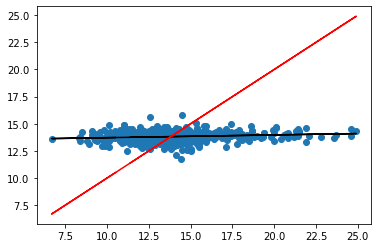

OBESITY_CrudePrev : 2237.7574615854764


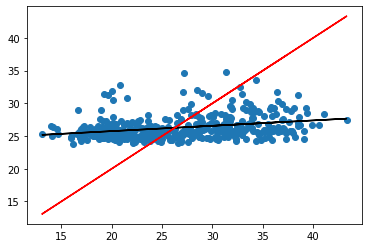

PHLTH_CrudePrev : 1122.5055362421226


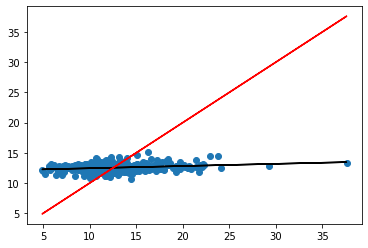

SLEEP_CrudePrev : 1611.6257663292795


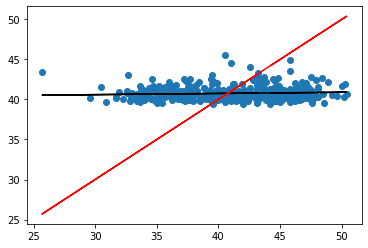

STROKE_CrudePrev : 369.09650198138445


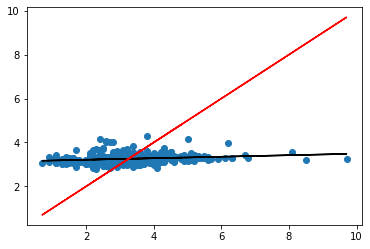

TEETHLOST_CrudePrev : 2441.687325751249


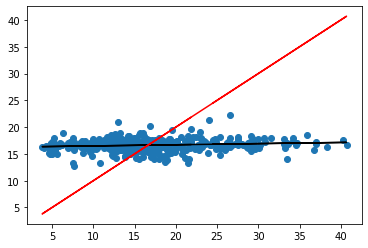

In [20]:
for k, model in scaled_linear.items():
    y_pred = model.predict(x_tests[k])
    slope, intercept, r_value, p_value, std_err = linregress(y_tests[k], y_pred.flatten())
    print(k, ':', np.sum(np.abs(y_pred - y_tests[k])))
    plt.scatter(y_tests[k], y_pred)
    plt.plot(y_tests[k], slope*y_tests[k]+intercept, 'k')
    plt.plot(y_tests[k], y_tests[k], 'r')
    plt.show()

ACCESS2_CrudePrev : 2660.3864829152135


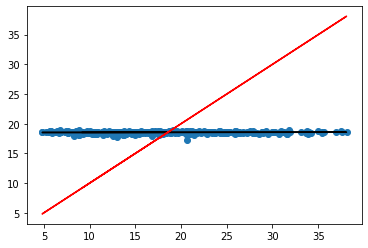

ARTHRITIS_CrudePrev : 1313.4449325277178


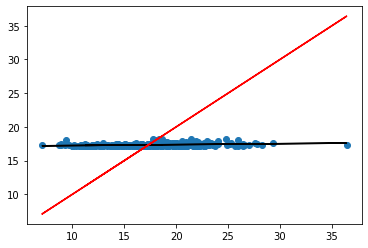

BINGE_CrudePrev : 1326.6037852546713


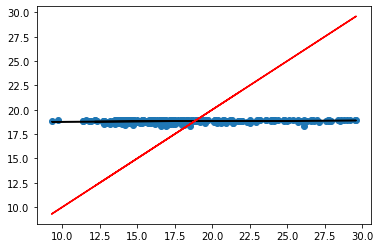

BPHIGH_CrudePrev : 1941.4492841302078


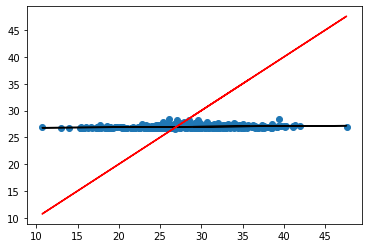

BPMED_CrudePrev : 1698.1955623237382


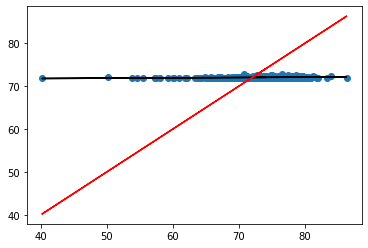

CANCER_CrudePrev : 510.2664506295148


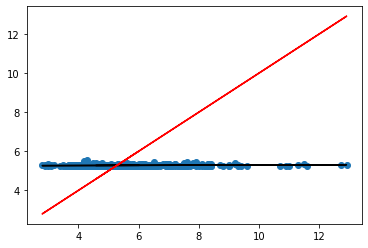

CASTHMA_CrudePrev : 608.5027849631203


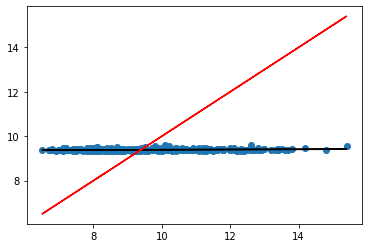

CERVICAL_CrudePrev : 1704.6324616297798


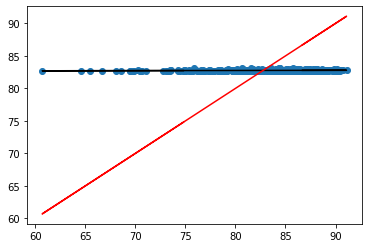

CHD_CrudePrev : 472.98704675842276


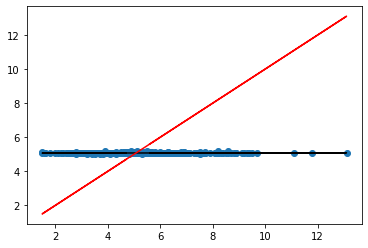

CHECKUP_CrudePrev : 1122.9260028722053


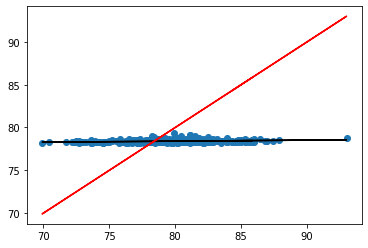

CHOLSCREEN_CrudePrev : 1094.7396676801459


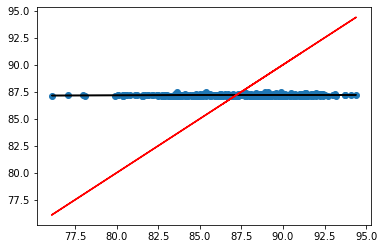

COLON_SCREEN_CrudePrev : 2553.551225781922


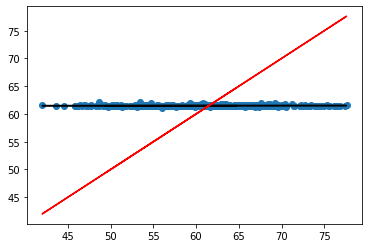

COPD_CrudePrev : 594.2316362401651


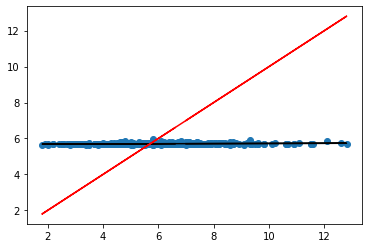

COREM_CrudePrev : 1603.0383986377594


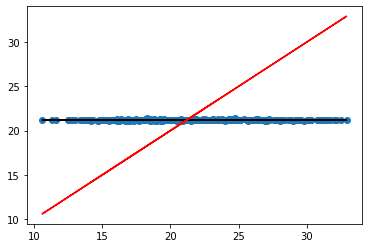

COREW_CrudePrev : 1247.375182629169


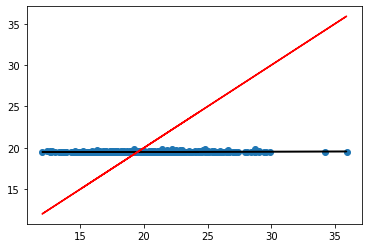

CSMOKING_CrudePrev : 1255.3239948555843


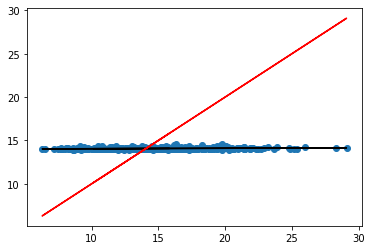

DENTAL_CrudePrev : 3698.0016437796457


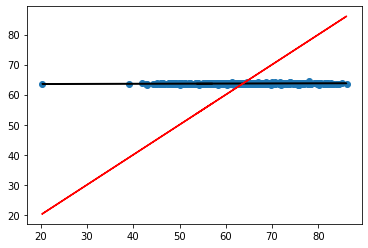

DEPRESSION_CrudePrev : 771.3740306862469


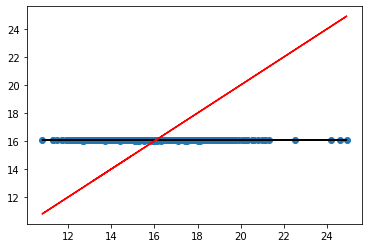

DIABETES_CrudePrev : 1270.9731531118928


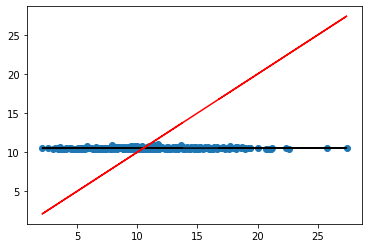

GHLTH_CrudePrev : 2629.2849894884976


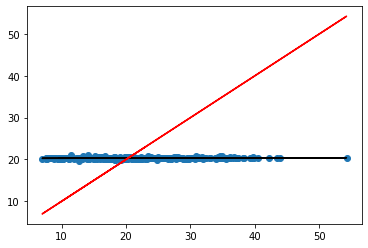

HIGHCHOL_CrudePrev : 1300.147948437678


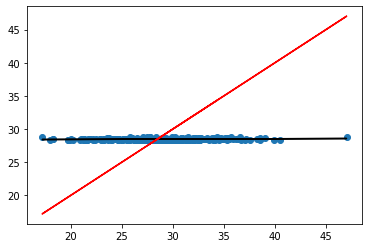

KIDNEY_CrudePrev : 258.93043938779954


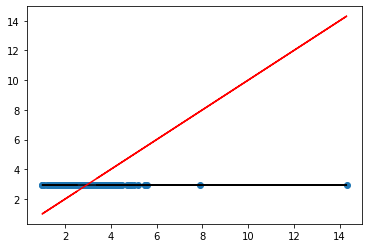

LPA_CrudePrev : 2899.1825303016813


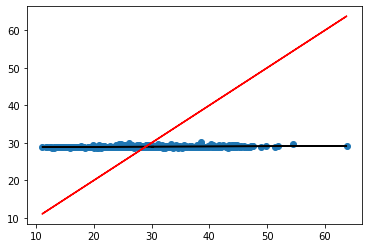

MAMMOUSE_CrudePrev : 1066.9882228025267


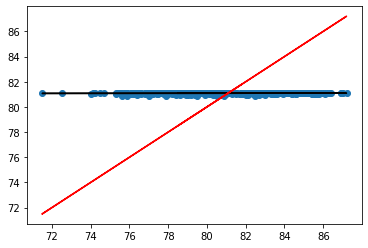

MHLTH_CrudePrev : 972.8713602992764


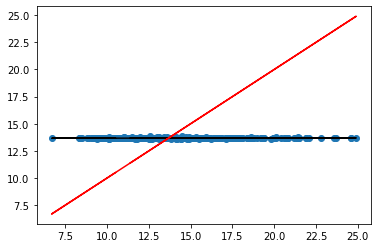

OBESITY_CrudePrev : 2446.1313539608714


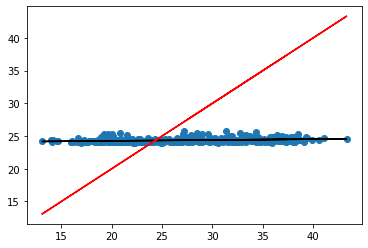

PHLTH_CrudePrev : 1127.3167267719768


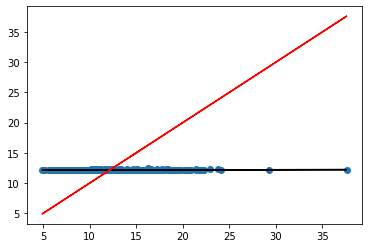

SLEEP_CrudePrev : 1673.8435571299703


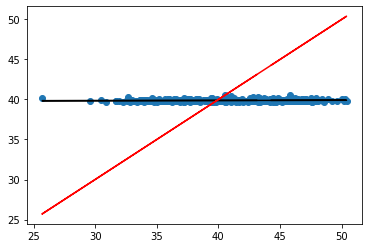

STROKE_CrudePrev : 372.30478936485304


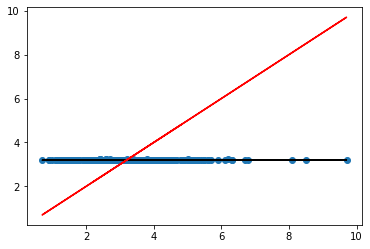

TEETHLOST_CrudePrev : 2442.0180622314665


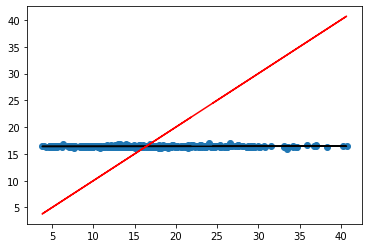

In [21]:
for k, model in unscaled_elastic.items():
    y_pred = model.predict(x_tests[k])
    slope, intercept, r_value, p_value, std_err = linregress(y_tests[k], y_pred.flatten())
    print(k, ':', np.sum(np.abs(y_pred - y_tests[k])))
    plt.scatter(y_tests[k], y_pred)
    plt.plot(y_tests[k], slope*y_tests[k]+intercept, 'k')
    plt.plot(y_tests[k], y_tests[k], 'r')
    plt.show()

ACCESS2_CrudePrev : 2599.305052488222


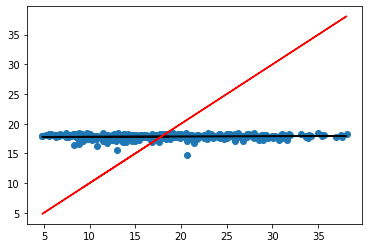

ARTHRITIS_CrudePrev : 1234.637300335308


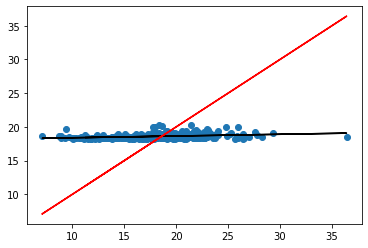

BINGE_CrudePrev : 1173.455832665213


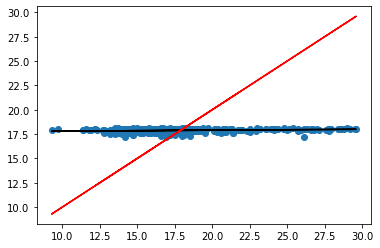

BPHIGH_CrudePrev : 1927.6519289269


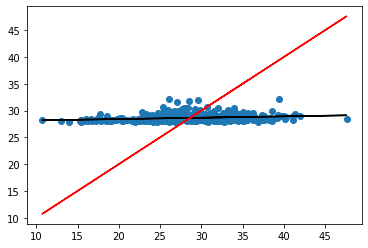

BPMED_CrudePrev : 1548.7902738099615


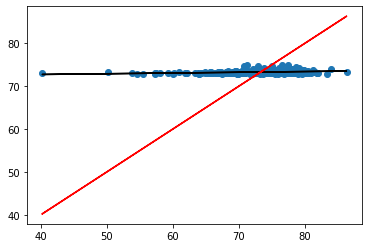

CANCER_CrudePrev : 526.6175428233903


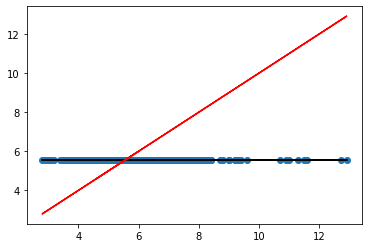

CASTHMA_CrudePrev : 624.2663319551092


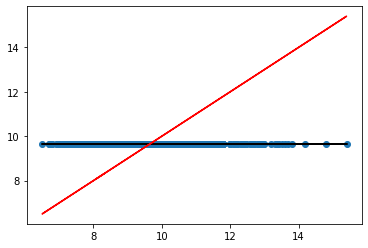

CERVICAL_CrudePrev : 1630.9200160481125


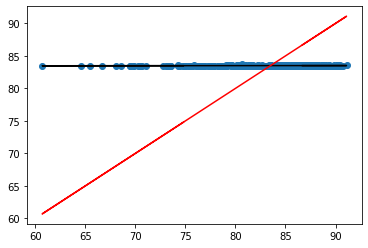

CHD_CrudePrev : 472.6613112817484


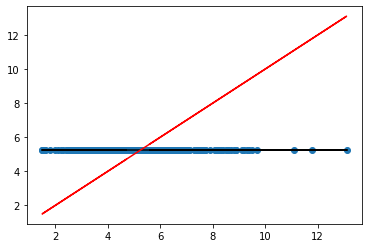

CHECKUP_CrudePrev : 1056.4645361019875


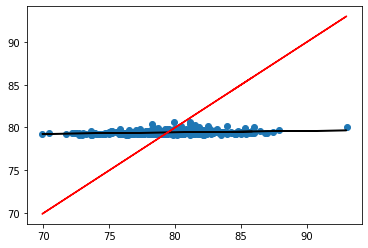

CHOLSCREEN_CrudePrev : 1077.3881866509157


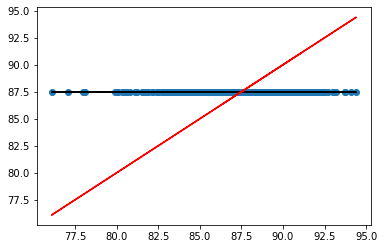

COLON_SCREEN_CrudePrev : 2558.068694624926


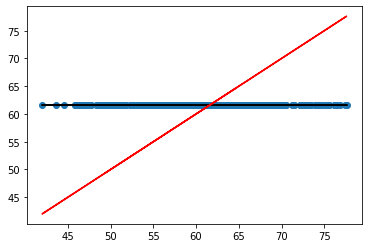

COPD_CrudePrev : 591.1777318369757


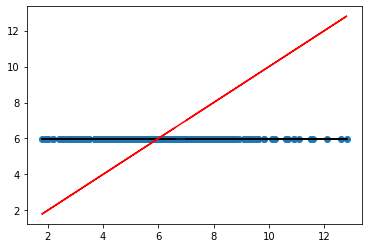

COREM_CrudePrev : 1614.4545293072824


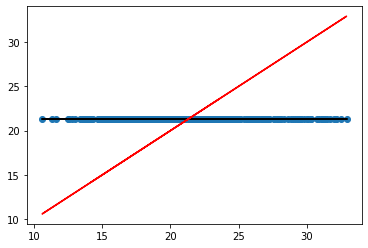

COREW_CrudePrev : 1272.0416913069191


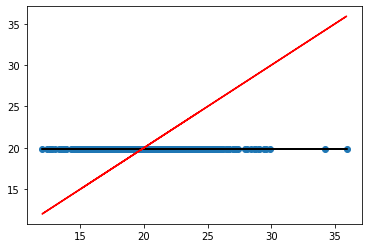

CSMOKING_CrudePrev : 1264.729468034523


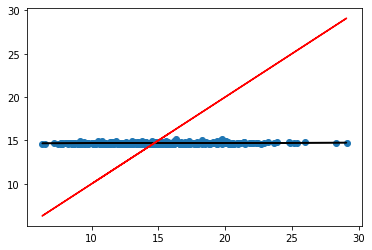

DENTAL_CrudePrev : 3711.6490833565463


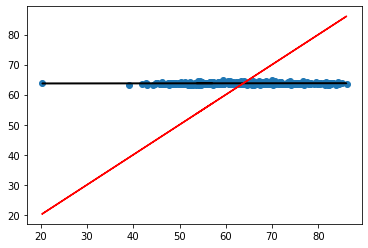

DEPRESSION_CrudePrev : 767.8978735971648


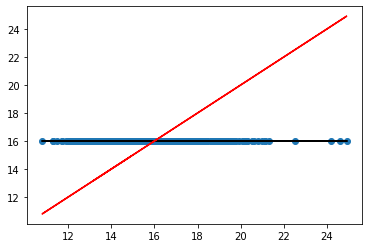

DIABETES_CrudePrev : 1257.9633739676879


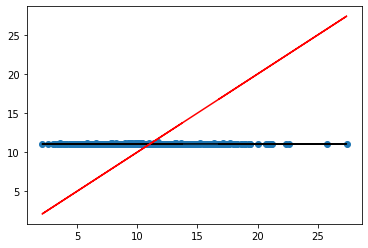

GHLTH_CrudePrev : 2640.3517013057144


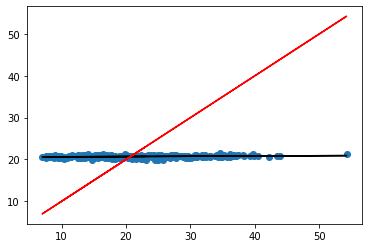

HIGHCHOL_CrudePrev : 1265.6000590667456


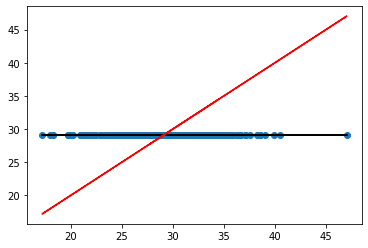

KIDNEY_CrudePrev : 259.5967513290018


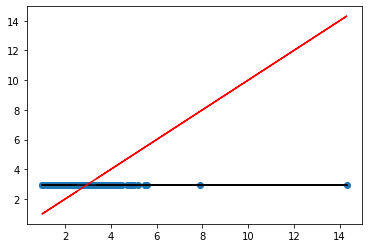

LPA_CrudePrev : 2869.909260693738


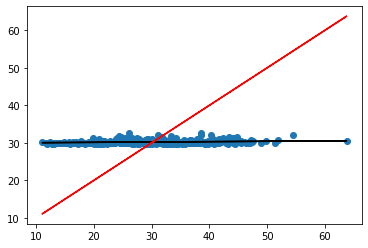

MAMMOUSE_CrudePrev : 1068.049645390071


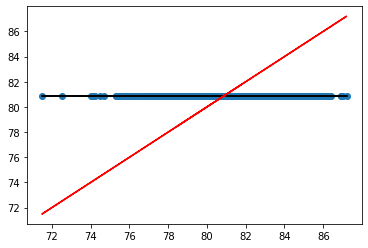

MHLTH_CrudePrev : 982.293975191967


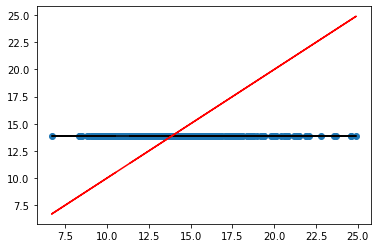

OBESITY_CrudePrev : 2306.1215837992268


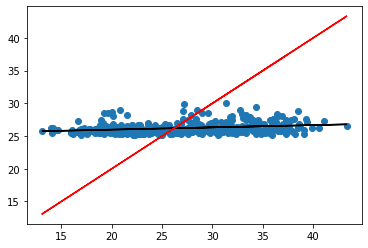

PHLTH_CrudePrev : 1138.361842882457


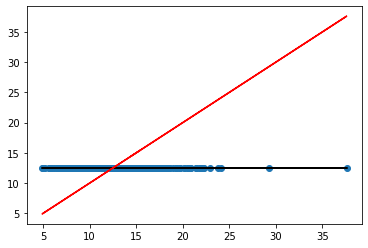

SLEEP_CrudePrev : 1611.916428667595


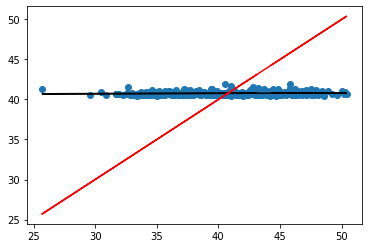

STROKE_CrudePrev : 375.5825753101004


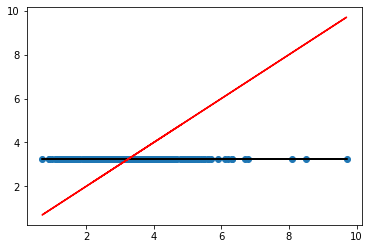

TEETHLOST_CrudePrev : 2447.1278177253084


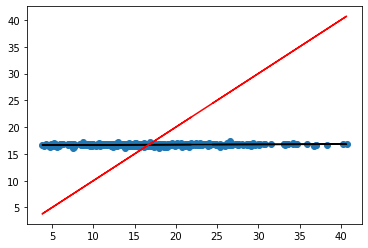

In [22]:
for k, model in scaled_elastic.items():
    y_pred = model.predict(x_tests[k])
    slope, intercept, r_value, p_value, std_err = linregress(y_tests[k], y_pred.flatten())
    print(k, ':', np.sum(np.abs(y_pred - y_tests[k])))
    plt.scatter(y_tests[k], y_pred)
    plt.plot(y_tests[k], slope*y_tests[k]+intercept, 'k')
    plt.plot(y_tests[k], y_tests[k], 'r')
    plt.show()

ACCESS2_CrudePrev : 1149491.0963947293


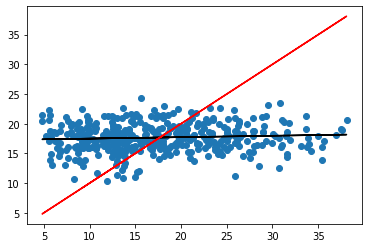

ARTHRITIS_CrudePrev : 572540.8870124817


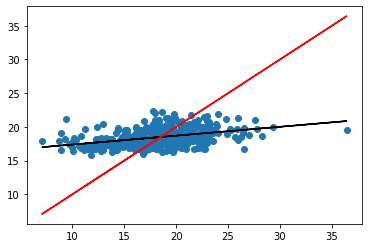

BINGE_CrudePrev : 540008.5963401794


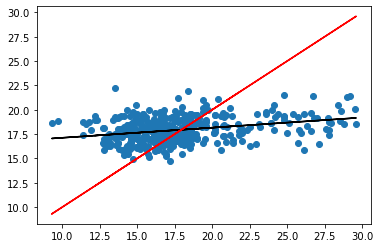

BPHIGH_CrudePrev : 920307.3343383787


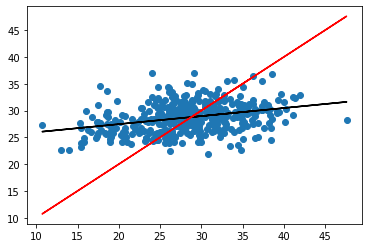

BPMED_CrudePrev : 736137.8171173097


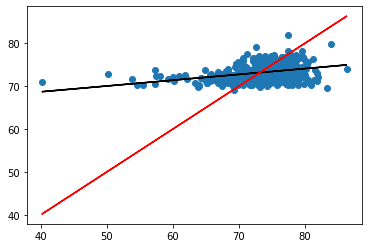

CANCER_CrudePrev : 237210.49233856198


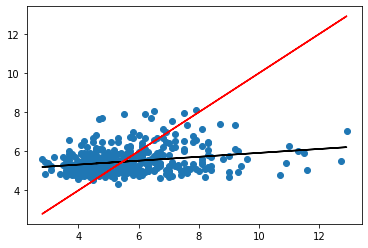

CASTHMA_CrudePrev : 276952.3045684814


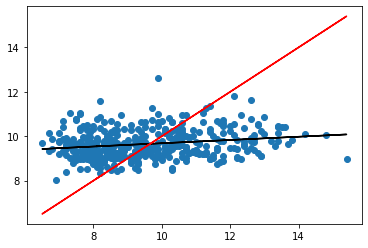

CERVICAL_CrudePrev : 743288.5175842284


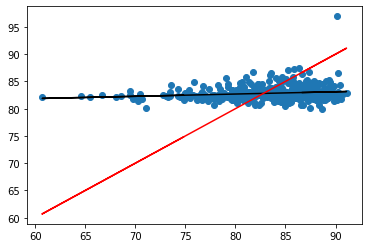

CHD_CrudePrev : 233296.8701649666


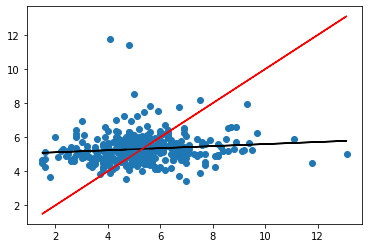

CHECKUP_CrudePrev : 491508.6513092041


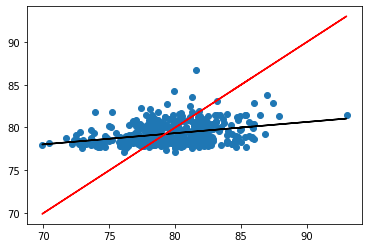

CHOLSCREEN_CrudePrev : 469049.7595855713


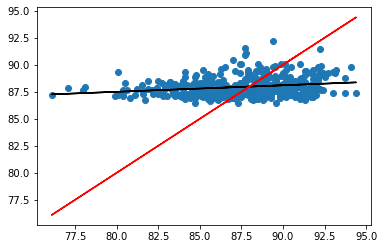

COLON_SCREEN_CrudePrev : 1131573.2855117798


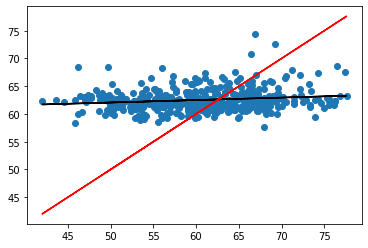

COPD_CrudePrev : 269225.1726770401


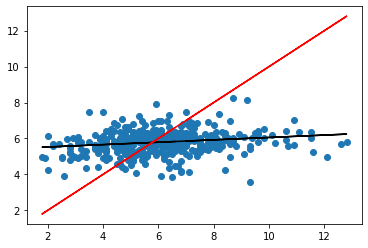

COREM_CrudePrev : 691456.0275199891


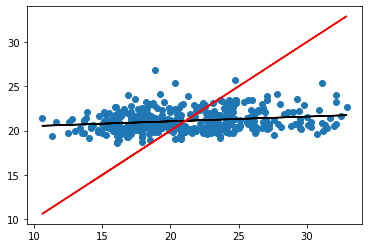

COREW_CrudePrev : 562537.9434856416


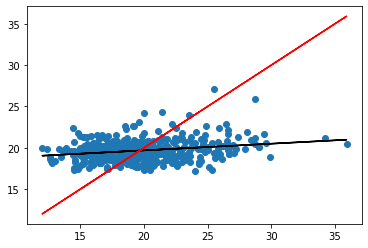

CSMOKING_CrudePrev : 576548.4466712952


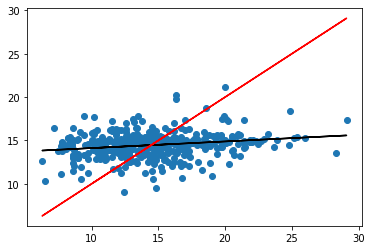

DENTAL_CrudePrev : 1620994.0044921874


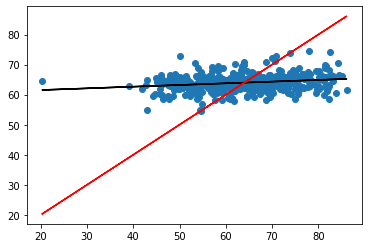

DEPRESSION_CrudePrev : 2139399.413635254


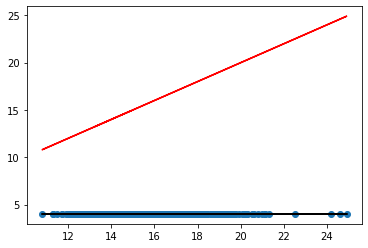

DIABETES_CrudePrev : 567513.7648468016


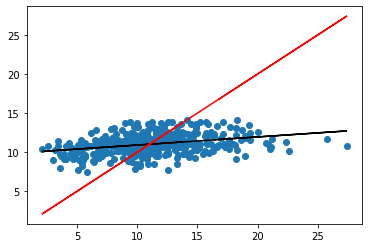

GHLTH_CrudePrev : 1168134.9226314547


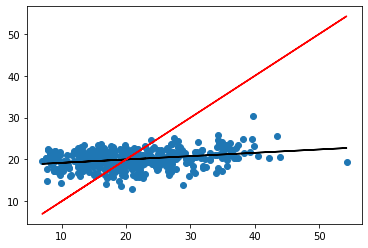

HIGHCHOL_CrudePrev : 568194.7460105895


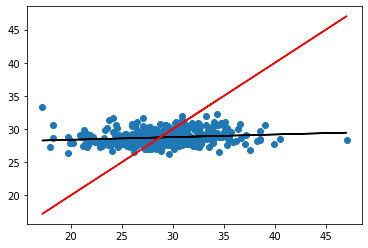

KIDNEY_CrudePrev : 117535.50146856306


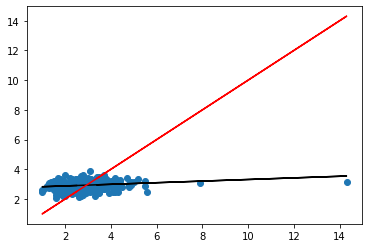

LPA_CrudePrev : 1276569.943196106


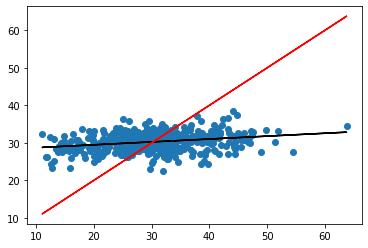

MAMMOUSE_CrudePrev : 475842.57698974607


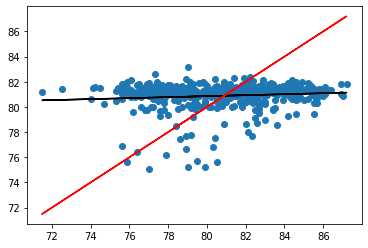

MHLTH_CrudePrev : 434407.1255809783


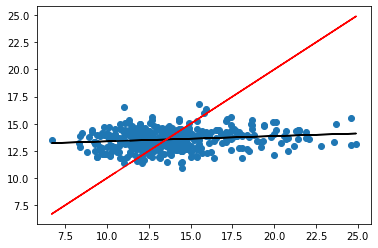

OBESITY_CrudePrev : 1051844.1127349853


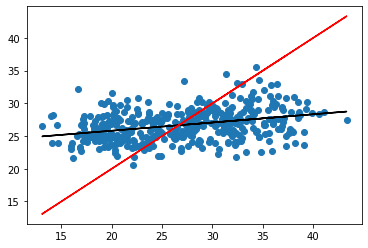

PHLTH_CrudePrev : 522033.4680173874


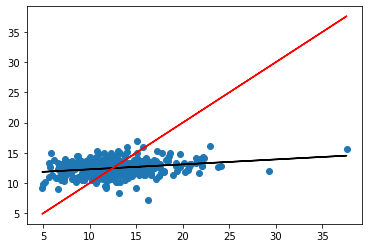

SLEEP_CrudePrev : 708510.0465698242


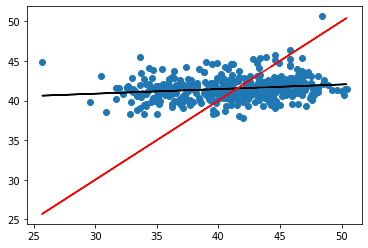

STROKE_CrudePrev : 168950.0077281952


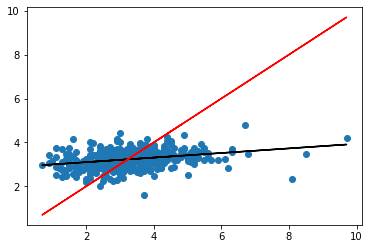

TEETHLOST_CrudePrev : 1095251.1920167925


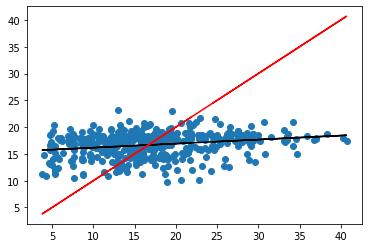

In [26]:
# Red - perfect fit; Black - actual fit
for k, model in models.items():
    y_pred = model.predict(x_tests[k])
    slope, intercept, r_value, p_value, std_err = linregress(y_tests[k], y_pred.flatten())
    print(k, ':', np.sum(np.abs(y_pred - y_tests[k])))  # Hmmm
    plt.scatter(y_tests[k], y_pred)
    plt.plot(y_tests[k], slope*y_tests[k]+intercept, 'k')
    plt.plot(y_tests[k], y_tests[k], 'r')
    plt.show()